In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import math
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

# Data

In [5]:
# Read data
motion = np.genfromtxt('../../dataset4_wbc/live_extraction/step_0.06/accelerations.csv', delimiter=',', dtype=np.float64)
contacts = np.genfromtxt('../../dataset4_wbc/live_extraction/step_0.06/accelerations.csv', delimiter=',', usecols=(57, 58, 59, 60), dtype=bool)
print("Motion data has a length of ", len(motion))

Motion data has a length of  56650


In [6]:
len(motion)

56650

In [7]:
i = 0
accelerations_idx = []
while i < (len(motion) - 1):
    if (motion[i, 1] != motion[i+1, 1] or motion[i, 2] != motion[i+1, 2] or motion[i, 3] != motion[i+1, 3]) and (motion[i, 1] >= 0.0 and motion[i+1, 1] >= 0.0):
        accelerations_idx.append(i)
        accelerations_idx.append(i+1)
    
    i += 1

accelerations_idx = np.array(accelerations_idx)

In [8]:
accelerations_idx.shape

(20174,)

In [9]:
motion[accelerations_idx].shape

(20174, 61)

In [10]:
contacts[accelerations_idx].shape

(20174, 4)

## Height-Force plots

In [12]:
def get_specific_cmd(dataset, fwd, side, rot):
    if abs(fwd): 
        return np.where(dataset[:, 1] > 0)[0] if fwd > 0 else np.where(dataset[:, 1] < 0)[0]
    if abs(side): 
        return np.where(dataset[:, 2] > 0)[0] if side > 0 else np.where(dataset[:, 2] < 0)[0]
    if abs(rot): 
        return np.where(dataset[:, 3] > 0)[0] if rot > 0 else np.where(dataset[:, 3] < 0)[0]

In [13]:
def get_swinging_motions(dataset, height=1):
    # rf min height (i.e swining motion)
    fl_min_height = np.where(dataset[:, 10] < height)[0]
    fr_min_height = np.where(dataset[:, 13] < height)[0]
    rl_min_height = np.where(dataset[:, 16] < height)[0]
    rr_min_height = np.where(dataset[:, 19] < height)[0]
            
    return fl_min_height,fr_min_height,rl_min_height,rr_min_height

### Step size

In [14]:
def get_step_size(dataset, footsteps, idx_coord=[8,11,14,17]):
    # Footsteps sizes
    step_size_fr = []
    step_size_fl = []
    step_size_rr = []
    step_size_rl = []
    footstep_period = []
    
    # Compute step sizes
    for idx, footstep in enumerate(footsteps):
        if idx > 0:
            time_diff = dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0]
            #print("Time diff: ", time_diff)

            if time_diff < 0.6 and time_diff > 0.3:
                footstep_period.append(time_diff)
                step_size_fl.append(dataset[footsteps[idx], idx_coord[0]] - dataset[footsteps[idx-1], idx_coord[0]])
                step_size_fr.append(dataset[footsteps[idx], idx_coord[1]] - dataset[footsteps[idx-1], idx_coord[1]])
                step_size_rl.append(dataset[footsteps[idx], idx_coord[2]] - dataset[footsteps[idx-1], idx_coord[2]])
                step_size_rr.append(dataset[footsteps[idx], idx_coord[3]] - dataset[footsteps[idx-1], idx_coord[3]])
    
    # Convert to numpy array
    step_size_fl_numpy = np.array(step_size_fl)
    step_size_fr_numpy = np.array(step_size_fr)
    step_size_rl_numpy = np.array(step_size_rl)
    step_size_rr_numpy = np.array(step_size_rr)
    footstep_period_numpy = np.array(footstep_period)
    
    # Only keep positive footsteps
    step_size_fl_numpy = step_size_fl_numpy[np.where(step_size_fl_numpy > 0)[0]]
    step_size_fr_numpy = step_size_fr_numpy[np.where(step_size_fr_numpy > 0)[0]]
    step_size_rl_numpy = step_size_rl_numpy[np.where(step_size_rl_numpy > 0)[0]]
    step_size_rr_numpy = step_size_rr_numpy[np.where(step_size_rr_numpy > 0)[0]]
                
    # Print average step-size
    print("Avg. step size time: ", np.mean(footstep_period_numpy))
    print("Min. step size time: ", np.min(footstep_period_numpy))
    print("Max. step size time: ", np.max(footstep_period_numpy))
    print("Std. step size time: ", np.std(footstep_period_numpy), "\n")
    #print(footstep_period_numpy)
    print("Avg. step size for fl foot: ", np.mean(step_size_fl_numpy))
    print("Avg. step size for fr foot: ", np.mean(step_size_fr_numpy))
    print("Avg. step size for rl foot: ", np.mean(step_size_rl_numpy))
    print("Avg. step size for rr foot: ", np.mean(step_size_rr_numpy), '\n')

    # Print std. dev. step-size
    print("Std. dev. step size for fl foot: ", np.std(step_size_fl_numpy))
    print("Std. dev. step size for fr foot: ", np.std(step_size_fr_numpy))
    print("Std. dev. step size for rl foot: ", np.std(step_size_rl_numpy))
    print("Std. dev. step size for rr foot: ", np.std(step_size_rr_numpy), '\n')
    
    return step_size_fr_numpy, step_size_fl_numpy, step_size_rr_numpy, step_size_rl_numpy

def step_size_statistics(dataset, footsteps, sign, motion, coordinates=[8,11,14,17]):
    # Step size and velocity along x axis
    for velocity in np.arange(0.1, 0.6, 0.1):
        print(f"Forward: Step size (x) {velocity * sign}")
        footsteps_velocity = footsteps[np.where((np.isclose(dataset[footsteps, motion], velocity * sign, 0.001)))[0]]
        step_size_fr_x_fwd,_,_,_ = get_step_size(dataset, footsteps_velocity, coordinates)
        print("\n")

#### Forward motion

In [15]:
footsteps_fwd = get_specific_cmd(motion, 1, 0, 0)

In [16]:
# Step size and velocity along x axis
step_size_statistics(motion, footsteps_fwd, 1, 1, [8,11,14,17])

Forward: Step size (x) 0.1
Avg. step size time:  0.3820847297617222
Min. step size time:  0.30088353157043457
Max. step size time:  0.5761086940765381
Std. step size time:  0.017544496313694865 

Avg. step size for fl foot:  0.013307096929287814
Avg. step size for fr foot:  0.015849006341067607
Avg. step size for rl foot:  0.01645048560010598
Avg. step size for rr foot:  0.013735103050725695 

Std. dev. step size for fl foot:  0.009341914999758448
Std. dev. step size for fr foot:  0.00999434680928636
Std. dev. step size for rl foot:  0.010305909221696415
Std. dev. step size for rr foot:  0.009914361202339425 



Forward: Step size (x) 0.2
Avg. step size time:  0.38137676174207025
Min. step size time:  0.3162822723388672
Max. step size time:  0.5451343059539795
Std. step size time:  0.013949375569719067 

Avg. step size for fl foot:  0.025289848544863283
Avg. step size for fr foot:  0.027671651806355755
Avg. step size for rl foot:  0.026704941783238734
Avg. step size for rr foot:  0.024

In [17]:
# Step size and velocity along y axis
step_size_statistics(motion, footsteps_fwd, 1, 1, [9,12,15,18])

Forward: Step size (x) 0.1
Avg. step size time:  0.3820847297617222
Min. step size time:  0.30088353157043457
Max. step size time:  0.5761086940765381
Std. step size time:  0.017544496313694865 

Avg. step size for fl foot:  0.015195821395179034
Avg. step size for fr foot:  0.015297339031976033
Avg. step size for rl foot:  0.015246225580521655
Avg. step size for rr foot:  0.016238843500530946 

Std. dev. step size for fl foot:  0.008939007472690875
Std. dev. step size for fr foot:  0.009756113671537999
Std. dev. step size for rl foot:  0.009447920160047711
Std. dev. step size for rr foot:  0.009618301642324951 



Forward: Step size (x) 0.2
Avg. step size time:  0.38137676174207025
Min. step size time:  0.3162822723388672
Max. step size time:  0.5451343059539795
Std. step size time:  0.013949375569719067 

Avg. step size for fl foot:  0.01566736553592109
Avg. step size for fr foot:  0.016951513211057312
Avg. step size for rl foot:  0.014934322231723456
Avg. step size for rr foot:  0.01

### Side motion (right)

In [18]:
footsteps_side_right = get_specific_cmd(motion, 0, -1, 0)

In [19]:
# Step size and velocity along x axis
step_size_statistics(motion, footsteps_side_right, -1, 2, [8,11,14,17])

Forward: Step size (x) -0.1
Avg. step size time:  0.37889661623476434
Min. step size time:  0.3285059928894043
Max. step size time:  0.5524115562438965
Std. step size time:  0.013144465695616307 

Avg. step size for fl foot:  0.0039471960407094
Avg. step size for fr foot:  0.0058373059832893415
Avg. step size for rl foot:  0.007455606762465234
Avg. step size for rr foot:  0.00499351611753741 

Std. dev. step size for fl foot:  0.00313445495023491
Std. dev. step size for fr foot:  0.004901263718304224
Std. dev. step size for rl foot:  0.004962164294699064
Std. dev. step size for rr foot:  0.0035800248882076084 



Forward: Step size (x) -0.2
Avg. step size time:  0.3815655937706258
Min. step size time:  0.3268611431121826
Max. step size time:  0.5554420948028564
Std. step size time:  0.018501769842566258 

Avg. step size for fl foot:  0.00466548021485747
Avg. step size for fr foot:  0.0054153666304458965
Avg. step size for rl foot:  0.008144017900066304
Avg. step size for rr foot:  0.00

In [20]:
# Step size and velocity along y axis
step_size_statistics(motion, footsteps_side_right, -1, 2, [9,12,15,18])

Forward: Step size (x) -0.1
Avg. step size time:  0.37889661623476434
Min. step size time:  0.3285059928894043
Max. step size time:  0.5524115562438965
Std. step size time:  0.013144465695616307 

Avg. step size for fl foot:  0.02043374914170511
Avg. step size for fr foot:  0.022364606684358482
Avg. step size for rl foot:  0.022161348057739446
Avg. step size for rr foot:  0.020800414449756863 

Std. dev. step size for fl foot:  0.015408029252604444
Std. dev. step size for fr foot:  0.014679687842784523
Std. dev. step size for rl foot:  0.013160609013083082
Std. dev. step size for rr foot:  0.017175214214228556 



Forward: Step size (x) -0.2
Avg. step size time:  0.3815655937706258
Min. step size time:  0.3268611431121826
Max. step size time:  0.5554420948028564
Std. step size time:  0.018501769842566258 

Avg. step size for fl foot:  0.02472504336099714
Avg. step size for fr foot:  0.03591132943588521
Avg. step size for rl foot:  0.03319667590236988
Avg. step size for rr foot:  0.0264

### Side motions (left)

In [21]:
footsteps_side_left = get_specific_cmd(motion, 0, 1, 0)

In [22]:
# Step size and velocity along x axis
step_size_statistics(motion, footsteps_side_left, 1, 2, [8,11,14,17])

Forward: Step size (x) 0.1
Avg. step size time:  0.3791609656547522
Min. step size time:  0.33429718017578125
Max. step size time:  0.5306448936462402
Std. step size time:  0.012771355363099571 

Avg. step size for fl foot:  0.006480194458439324
Avg. step size for fr foot:  0.004529892786538646
Avg. step size for rl foot:  0.007763871538112385
Avg. step size for rr foot:  0.006111110583429039 

Std. dev. step size for fl foot:  0.004681139386568822
Std. dev. step size for fr foot:  0.0035473617079192937
Std. dev. step size for rl foot:  0.004072980542697353
Std. dev. step size for rr foot:  0.004643268772594206 



Forward: Step size (x) 0.2
Avg. step size time:  0.37886600501905854
Min. step size time:  0.32104945182800293
Max. step size time:  0.5535316467285156
Std. step size time:  0.014469355738041817 

Avg. step size for fl foot:  0.007217549138108429
Avg. step size for fr foot:  0.004364219232919292
Avg. step size for rl foot:  0.005291386194862872
Avg. step size for rr foot:  0

In [23]:
# Step size and velocity along y axis
step_size_statistics(motion, footsteps_side_left, 1, 2, [9,12,15,18])

Forward: Step size (x) 0.1
Avg. step size time:  0.3791609656547522
Min. step size time:  0.33429718017578125
Max. step size time:  0.5306448936462402
Std. step size time:  0.012771355363099571 

Avg. step size for fl foot:  0.016633719440180716
Avg. step size for fr foot:  0.02744839887982794
Avg. step size for rl foot:  0.028684904986971953
Avg. step size for rr foot:  0.018089659675367995 

Std. dev. step size for fl foot:  0.013129361441769238
Std. dev. step size for fr foot:  0.014537215375780146
Std. dev. step size for rl foot:  0.016311739967842787
Std. dev. step size for rr foot:  0.011441203135405998 



Forward: Step size (x) 0.2
Avg. step size time:  0.37886600501905854
Min. step size time:  0.32104945182800293
Max. step size time:  0.5535316467285156
Std. step size time:  0.014469355738041817 

Avg. step size for fl foot:  0.034900753598846694
Avg. step size for fr foot:  0.024617486114459623
Avg. step size for rl foot:  0.02790422205141259
Avg. step size for rr foot:  0.03

### Rotation (clockwise)

In [24]:
# Step size and velocity along x axis
step_size_statistics(motion_clock, footsteps_clock, -1, 3, [8,11,14,17])

NameError: name 'motion_clock' is not defined

In [25]:
# Step size along y axis 
step_size_statistics(motion_clock, footsteps_01_clock, -1, 3, [9,12,15,18])

NameError: name 'motion_clock' is not defined

### Rotation (counter clockwise)

In [26]:
# Step size and velocity along x axis 
step_size_statistics(motion_count, footsteps_count, 1, 3, [8,11,14,17])

NameError: name 'motion_count' is not defined

In [27]:
# Step size along y axis 
step_size_statistics(motion_count, footsteps_count, 1, 3, [9,12,15,18])

NameError: name 'motion_count' is not defined

### Footstep visualization

In [15]:
def euler_from_quaternion(x, y, z, w):
    """
    Convert a quaternion into euler angles (roll, pitch, yaw)
    roll is rotation around x in radians (counterclockwise)
    pitch is rotation around y in radians (counterclockwise)
    yaw is rotation around z in radians (counterclockwise)
    """
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll_x = math.atan2(t0, t1)
     
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch_y = math.asin(t2)
     
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw_z = math.atan2(t3, t4)
     
    return roll_x, pitch_y, yaw_z # in radians

In [16]:
def visualize_static_foosteps(dataset, footsteps):
    old_xs = None
    old_ys = None
    old_zs = None
    
    # Visualize footsteps
    for idx, footstep in enumerate(footsteps):
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

        #ax.set_xlim([-0.5, 0.5])
        #ax.set_ylim([-0.3, 0.3])
        ax.set_zlim([-0.5, 0.5])

        dataset[footstep, 8:20] = np.round(dataset[footstep, 8:20], 3)
        
        time_diff = dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0]
            
        # 3D positions        
        xs = np.array([dataset[footstep, 8], dataset[footstep, 11], dataset[footstep, 14], dataset[footstep, 17]])
        ys = np.array([dataset[footstep, 9], dataset[footstep, 12], dataset[footstep, 15], dataset[footstep, 18]])
        zz = np.array([dataset[footstep, 10], dataset[footstep, 13], dataset[footstep, 16], dataset[footstep, 19]])

        ax.scatter(xs, ys, zs, marker='o')

        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')

        plt.show()

        #print(xs, ys, zs, dataset[footstep, 2:5], dataset[footstep, 25:28])
        if idx > 0 and idx < len(footsteps):
            print(f'Diff: {time_diff}. Command: {dataset[footstep, 1:4]}. Coord: {[xs[0], ys[0], zs[0]]}. Step size: {[xs[0]-old_xs[0], ys[0]-old_ys[0], zs[0]-old_zs[0]]}.')
        else:
            print(f'Command: {dataset[footstep, 1:4]}. Coord: {[xs[0], ys[0], zs[0]]}.')
            
        old_xs = xs
        old_ys = ys
        old_zs = zs

In [17]:
def update_points(num, dataset, footsteps, x, y, z, points):    
    # Starting footstep index
    footstep = footsteps[num]
    
    # Round footsteps position
    dataset[footstep, 8:20] = np.round(dataset[footstep, 8:20], 3)

    # Initial footsteps 3D positions
    new_x = np.array([dataset[footstep, 8], dataset[footstep, 11], dataset[footstep, 14], dataset[footstep, 17]])
    new_y = np.array([dataset[footstep, 9], dataset[footstep, 12], dataset[footstep, 15], dataset[footstep, 18]])
    new_z = np.array([dataset[footstep, 10], dataset[footstep, 13], dataset[footstep, 16], dataset[footstep, 19]])

    # update properties
    points.set_data(new_x, new_y)
    points.set_3d_properties(new_z, 'z')

    # return modified artists
    return points

def visualize_animated_footsteps(dataset, footsteps, style: str):
    # Create figure
    fig = plt.figure()
    ax = p3.Axes3D(fig)

    # Setting the axes properties
    ax.set_xlim3d([-0.4, 0.4])
    ax.set_xlabel('X')

    ax.set_ylim3d([-0.2, 0.2])
    ax.set_ylabel('Y')

    ax.set_zlim3d([-0.5, 0.5])
    ax.set_zlabel('Z')

    # Starting footstep index
    footstep = footsteps[0]

    # Round footsteps position
    dataset[footstep, 8:20] = np.round(dataset[footstep, 8:20], 3)

    # Initial footsteps 3D positions
    x = np.array([dataset[footstep, 8], dataset[footstep, 11], dataset[footstep, 14], dataset[footstep, 17]])
    y = np.array([dataset[footstep, 9], dataset[footstep, 12], dataset[footstep, 15], dataset[footstep, 18]])
    z = np.array([dataset[footstep, 10], dataset[footstep, 13], dataset[footstep, 16], dataset[footstep, 19]])

    txt = fig.suptitle('')
    points, = ax.plot(x, y, z, style)
    
    # blit=True re-draws only the parts that have changed.
    anim = animation.FuncAnimation(fig, update_points, frames=len(footsteps), fargs=(dataset, footsteps, x, y, z, points))
    
    return anim   

In [18]:
def visualize_absolute_foostep_sizes(dataset, footsteps):
    prev_yaw = 0
    
    # Visualize footsteps
    for idx, footstep in enumerate(footsteps):
        dataset[footstep, 8:20] = np.round(dataset[footstep, 8:20], 3)
        
        if idx < (len(footsteps) - 1):
            print("Command: ", dataset[footstep, 1:4])
            time_difference = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx+1], 0])
            
            if time_difference < 1:
                fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
                axes[0].set_xlabel('X Label')
                axes[0].set_ylabel('Y Label')
                axes[1].set_xlabel('X Label')
                axes[1].set_ylabel('Y Label')
                    
                # Get euler angles from odom to base rotation
                _, _, curh_yaw = euler_from_quaternion(dataset[footstep, 47], dataset[footstep, 48], dataset[footstep, 49], dataset[footstep, 50])
                _, _, next_yaw = euler_from_quaternion(dataset[footsteps[idx+1], 47], dataset[footsteps[idx+1], 48], dataset[footsteps[idx+1], 49], dataset[footsteps[idx+1], 50])

                # Compute rotation matrix
                c_curh, s_curh = np.cos(curh_yaw), np.sin(curh_yaw)
                c_next, s_next = np.cos(next_yaw), np.sin(next_yaw)
                R_curh = np.array(((c_curh, -s_curh), (s_curh, c_curh)))
                R_next = np.array(((c_next, -s_next), (s_next, c_next)))
                
                # Odom base vectors
                curh_base = np.array([[dataset[footstep, 44], dataset[footstep, 45]]])
                next_base = np.array([[dataset[footsteps[idx+1], 44], dataset[footsteps[idx+1], 45]]])
                
                # Local base vectors
                local_curh_base = R_curh.T @ curh_base.T
                local_next_base = R_curh.T @ next_base.T
                local_next_base_next = R_next.T @ next_base.T
                base_displacement = local_next_base - local_curh_base
                
                #print("Footstep timestamp: ", dataset[footstep, 0])
                print(f'\nFL moving: {contacts[idx, 0]}. FR moving: {contacts[idx, 1]}')
                print(f'RL moving: {contacts[idx, 2]}. RR moving: {contacts[idx, 3]}')
                
                #print(f'Curh base (not transformed): {dataset[footstep, 31:33]}. Next base (not transformed): {dataset[footsteps[idx+1], 31:33]}.')
                #print(f'Curh base transformed (x): {local_curh_base.tolist()}.\nNext base transformed (y): {local_next_base.tolist()}.\nNext base transformed2 (y): {local_next_base_next.tolist()}\n')
                print(prev_yaw, curh_yaw)
                print(f'Base displacement: {base_displacement.tolist()}. Rotation displacement: {(curh_yaw - prev_yaw) * 180 / np.pi}.\n')
                
                print("CoM displacement: ")
                print(f'lf (x): {dataset[footsteps[idx], 8]}, {dataset[footsteps[idx+1], 8]}, lf (y): {dataset[footsteps[idx], 9]}, {dataset[footsteps[idx+1], 9]}.')
                print(f'lf displacement: {(dataset[footsteps[idx+1], 8] - dataset[footsteps[idx], 8]).tolist()}, {(dataset[footsteps[idx+1], 9] - dataset[footsteps[idx], 9]).tolist()}.\n')
                
                print(f'lh (x): {dataset[footsteps[idx], 11]}, {dataset[footsteps[idx+1], 11]}, lh (y): {dataset[footsteps[idx], 12]}, {dataset[footsteps[idx+1], 12]}.')
                print(f'lh displacement: {(dataset[footsteps[idx+1], 11] - dataset[footsteps[idx], 11]).tolist()}, {(dataset[footsteps[idx+1], 12] - dataset[footsteps[idx], 12]).tolist()}.\n')
                
                print(f'rf (x): {dataset[footsteps[idx], 14]}, {dataset[footsteps[idx+1], 14]}, rf (y): {dataset[footsteps[idx], 15]}, {dataset[footsteps[idx+1], 15]}.')
                print(f'rf displacement: {(dataset[footsteps[idx+1], 14] - dataset[footsteps[idx], 14]).tolist()}, {(dataset[footsteps[idx+1], 15] - dataset[footsteps[idx], 15]).tolist()}.\n')
                
                print(f'rh (x): {dataset[footsteps[idx], 17]}, {dataset[footsteps[idx+1], 17]}, rh (y): {dataset[footsteps[idx], 18]}, {dataset[footsteps[idx+1], 18]}.')
                print(f'rh displacement: {(dataset[footsteps[idx+1], 17] - dataset[footsteps[idx], 17]).tolist()}, {(dataset[footsteps[idx+1], 18] - dataset[footsteps[idx], 18]).tolist()}.\n')
        
                # Feet displacements
                lf_x_displacement = dataset[footsteps[idx+1], 8] - dataset[footsteps[idx], 8]
                lf_y_displacement = dataset[footsteps[idx+1], 9] - dataset[footsteps[idx], 9]
                lh_x_displacement = dataset[footsteps[idx+1], 11] - dataset[footsteps[idx], 11]
                lh_y_displacement = dataset[footsteps[idx+1], 12] - dataset[footsteps[idx], 12]
                rf_x_displacement = dataset[footsteps[idx+1], 14] - dataset[footsteps[idx], 14]
                rf_y_displacement = dataset[footsteps[idx+1], 15] - dataset[footsteps[idx], 15]
                rh_x_displacement = dataset[footsteps[idx+1], 17] - dataset[footsteps[idx], 17]
                rh_y_displacement = dataset[footsteps[idx+1], 18] - dataset[footsteps[idx], 18]
                
                # Support foot base displacement
                support_base_displacement = [0, 0]
                if contacts[idx, 1]:
                    support_base_displacement[0] = -lf_x_displacement
                    support_base_displacement[1] = -lf_y_displacement
                else:
                    support_base_displacement[0] = -rf_x_displacement
                    support_base_displacement[1] = -rf_y_displacement
                
                prev_yaw = curh_yaw
                    
                print(f'\nBase displacement (CoM): {support_base_displacement}.\n')
                    
                x_0 = np.array([dataset[footstep, 8], 
                                dataset[footstep, 11],
                                dataset[footstep, 14], 
                                dataset[footstep, 17]])
                y_0 = np.array([dataset[footstep, 9], 
                                dataset[footstep, 12],
                                dataset[footstep, 15], 
                                dataset[footstep, 18]])
                
                """
                x_1 = np.array([dataset[footsteps[idx+1], 7], 
                                dataset[footsteps[idx+1], 10],
                                dataset[footsteps[idx+1], 13], 
                                dataset[footsteps[idx+1], 16]])
                y_1 = np.array([dataset[footsteps[idx+1], 8], 
                                dataset[footsteps[idx+1], 11],
                                dataset[footsteps[idx+1], 14], 
                                dataset[footsteps[idx+1], 17]])
                """
                
                x_1 = np.array([dataset[footstep, 8] + lf_x_displacement, 
                                dataset[footstep, 11] + rf_x_displacement,
                                dataset[footstep, 14] + lh_x_displacement, 
                                dataset[footstep, 17] + rh_x_displacement])
                y_1 = np.array([dataset[footstep, 9] + lf_y_displacement, 
                                dataset[footstep, 12] + rf_y_displacement,
                                dataset[footstep, 15] + lh_y_displacement, 
                                dataset[footstep, 18] + rh_y_displacement])
                
                #axes[0].scatter(x_0, y_0, c= 'b',marker='o')
                axes[0].scatter(x_0, y_0, c= 'm',marker='o')
                axes[0].scatter(0, 0, c= 'g', marker='^')
                axes[0].scatter(base_displacement[0], base_displacement[1], c= 'y', marker='^')
                axes[0].scatter(support_base_displacement[0], support_base_displacement[1], c= 'r', marker='^')
                
                axes[1].scatter(x_1, y_1, c= 'r', marker='o')
                axes[1].scatter(x_1, y_1, c= 'c', marker='o')
                
                plt.show()
                
#visualize_absolute_foostep_sizes(motion, footsteps_fwd)                  

### Forward motion

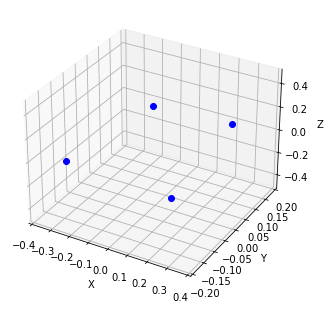

In [28]:
anim = visualize_animated_footsteps(motion, footsteps_fwd, "bo")
HTML(anim.to_html5_video())

### Side motion (right)

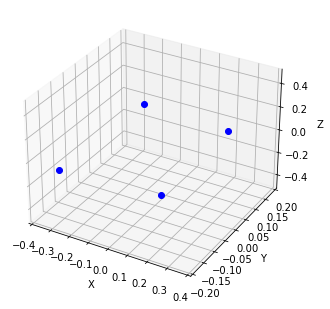

In [29]:
anim = visualize_animated_footsteps(motion, footsteps_side_right, "bo")
HTML(anim.to_html5_video())

### Side motion (left)

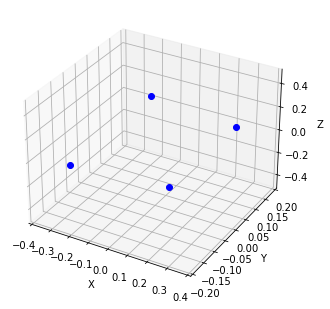

In [30]:
anim = visualize_animated_footsteps(motion, footsteps_side_left, "bo")
HTML(anim.to_html5_video())

### Rotation (clockwise)

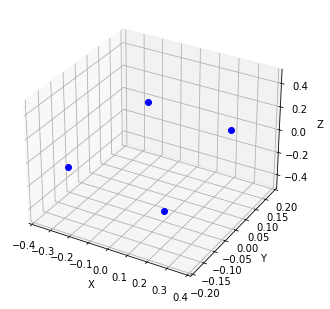

In [210]:
anim = visualize_animated_footsteps(motion_clock, footsteps_01_clock, "bo")
HTML(anim.to_html5_video())

### Rotation (counter clockwise)

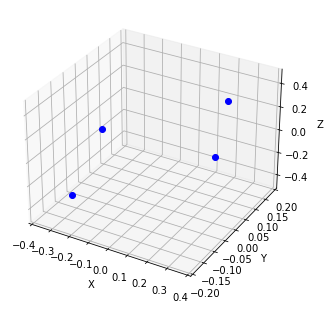

In [211]:
anim = visualize_animated_footsteps(motion_count, footsteps_count, "bo")
HTML(anim.to_html5_video())

# Dataset Preparation

In [32]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [47]:
def relative_footstep_accelerations_prediction_dataset(dataset, footsteps, debug=False):
    # Footsteps sizes
    inputs = []
    labels = []
    last_footsteps = np.array([0, 0, 0, 0])
    
    idx = 0
    while idx < (len(footsteps) -1):
        # Compute time difference between
        # curhent and next footsteps
        time_difference = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx+1], 0])
        
        if time_difference < 0.5 and dataset[footsteps[idx], 1:4].tolist() != dataset[footsteps[idx+1], 1:4].tolist():
            fl_moving = contacts[idx+1, 0]
            fr_moving = contacts[idx+1, 1]
            rl_moving = contacts[idx+1, 2]
            rr_moving = contacts[idx+1, 3]
                
            if debug:
                print("Time difference: ", time_difference)
                print("Footstep timestamp: ", dataset[footstep, 0])
                print(f'lf moving: {fl_moving}. rf moving: {fr_moving}')
                print(f'lh moving: {rl_moving}. rh moving: {rr_moving}')

            if (not fr_moving != fl_moving or not fr_moving == rl_moving or not fl_moving == rr_moving):
                print("Exception")
                print("Time difference: ", time_difference)
                #print("Footstep timestamp: ", dataset[footstep, 0])
                print(f'fl moving: {fl_moving}. fr moving: {fr_moving}')
                print(f'rl moving: {rl_moving}. rr moving: {rr_moving}')
                continue
                
            assert fr_moving == rl_moving
            assert rr_moving == fl_moving
            assert fr_moving != fl_moving
            
            inputs.append(dataset[footsteps[idx], 1:4].tolist() + 
                          dataset[footsteps[idx], 51:57].tolist() + 
                          dataset[footsteps[idx], 8:20].tolist() + 
                          contacts[footsteps[idx+1], :].tolist() + 
                          dataset[footsteps[idx+1], 1:4].tolist() +
                          last_footsteps.tolist())
            
            
            #labels.append(dataset[footsteps[idx+1], 8:10].tolist() +  dataset[footsteps[idx+1], 11:13].tolist() + dataset[footsteps[idx+1], 14:16].tolist() + dataset[footsteps[idx+1], 17:19].tolist())
             
            if fr_moving:
                labels.append([(dataset[footsteps[idx+1], 44] + dataset[footsteps[idx+1], 11]) - (dataset[footsteps[idx], 44] + dataset[footsteps[idx], 11]),
                               (dataset[footsteps[idx+1], 45] + dataset[footsteps[idx+1], 12]) - (dataset[footsteps[idx], 45] + dataset[footsteps[idx], 12]),
                               (dataset[footsteps[idx+1], 44] + dataset[footsteps[idx+1], 14]) - (dataset[footsteps[idx], 44] + dataset[footsteps[idx], 14]),
                               (dataset[footsteps[idx+1], 45] + dataset[footsteps[idx+1], 15]) - (dataset[footsteps[idx], 45] + dataset[footsteps[idx], 15])])
            else:
                labels.append([(dataset[footsteps[idx+1], 44] + dataset[footsteps[idx+1], 8]) - (dataset[footsteps[idx], 44] + dataset[footsteps[idx], 8]),
                               (dataset[footsteps[idx+1], 45] + dataset[footsteps[idx+1], 9]) - (dataset[footsteps[idx], 45] + dataset[footsteps[idx], 9]),
                               (dataset[footsteps[idx+1], 44] + dataset[footsteps[idx+1], 17]) - (dataset[footsteps[idx], 44] + dataset[footsteps[idx], 17]),
                               (dataset[footsteps[idx+1], 45] + dataset[footsteps[idx+1], 18]) - (dataset[footsteps[idx], 45] + dataset[footsteps[idx], 18])])
            
            last_footsteps = labels[-1]
        
            
        idx += 1
                                    
    # Convert to numpy array
    inputs_numpy = np.array(inputs)
    labels_numpy = np.array(labels)
    
    return inputs_numpy, labels_numpy

X_relative_footsteps_acc_absolute, Y_relative_footsteps_acc_absolute = relative_footstep_accelerations_prediction_dataset(motion, accelerations_idx)
print(X_relative_footsteps_acc_absolute.shape)
print(Y_relative_footsteps_acc_absolute.shape)

(9780, 28)
(9780, 4)


In [48]:
%store X_relative_footsteps_acc_absolute
%store Y_relative_footsteps_acc_absolute

Stored 'X_relative_footsteps_acc_absolute' (ndarray)
Stored 'Y_relative_footsteps_acc_absolute' (ndarray)


In [50]:
X_relative_footsteps_acc_absolute[:10, :3]

array([[ 0. ,  0. ,  0. ],
       [ 0. ,  0. , -0.1],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. , -0.1],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. , -0.1],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. , -0.1],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. , -0.1]])

In [52]:
Y_relative_footsteps_acc_absolute[:10, :2]

array([[-0.00021378, -0.00052315],
       [-0.0003851 , -0.0033641 ],
       [ 0.00482058, -0.00534108],
       [ 0.00849004, -0.0006769 ],
       [-0.00651516, -0.00072603],
       [-0.0142432 ,  0.00625676],
       [-0.0099761 ,  0.00117827],
       [ 0.01401415, -0.0045306 ],
       [ 0.01737789, -0.00868419],
       [ 0.01812109, -0.00629361]])